# Global settings

In [6]:
%matplotlib inline

#%load_ext autoreload  # Autoreload has a bug : when you modify function in source code and run again, python kernel hangs :(
#%autoreload 2

import datetime as dt

import sys, importlib

from functions import *
importlib.reload(sys.modules['functions'])

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

import datetime as dt

import os
import zipfile
import urllib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np   
  
import plotly as py
import plotly.graph_objects as go
import ipywidgets as widgets

import qgrid

import glob

from pandas.plotting import scatter_matrix

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import entropy

from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


import nltk
import codecs

#from nltk.corpus.reader.api import CorpusReader
#from nltk.corpus.reader.api import CategorizedCorpusReader

from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

import pandas_profiling


DATA_PATH = os.path.join("datasets", "stackexchange")
#DATA_PATH = os.path.join(DATA_PATH, "out")

#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults_20190101-20200620.csv")
#DATA_PATH_FILE_INPUT = os.path.join(DATA_PATH, "QueryResults 20200301-20200620_1.csv")

DATA_PATH_FILE = os.path.join(DATA_PATH, "*.csv")
ALL_FILES_LIST = glob.glob(DATA_PATH_FILE)

ALL_FEATURES = []

MODEL_CLIENT_FEATURES = ['TotalPricePerMonth', 'DescriptionNormalized', 'HasEverCancelled', 'BoughtTopValueProduct' ]


plt.rcParams["figure.figsize"] = [16,9] # Taille par défaut des figures de matplotlib

import seaborn as sns
from seaborn import boxplot
sns.set()

#import common_functions

####### Paramètres pour sauver et restaurer les modèles :
import pickle
####### Paramètres à changer par l'utilisateur selon son besoin :

'''
RECOMPUTE_GRIDSEARCH = True  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = False # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX
                          # Grid search results are loaded with full samples (SAMPLED_DATA must be False)
'''


RECOMPUTE_GRIDSEARCH = False  # CAUTION : computation is several hours long
SAVE_GRID_RESULTS = False # If True : grid results object will be saved to pickle files that have GRIDSEARCH_FILE_PREFIX
LOAD_GRID_RESULTS = True # If True : grid results object will be loaded from pickle files that have GRIDSEARCH_FILE_PREFIX

#GRIDSEARCH_CSV_FILE = 'grid_search_results.csv'

GRIDSEARCH_FILE_PREFIX = 'grid_search_results_'

EXECUTE_INTERMEDIATE_MODELS = True # If True: every intermediate model (which results are manually analyzed in the notebook) will be executed


# Necessary for predictors used in the notebook :
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures

### For progress bar :
from tqdm import tqdm_notebook as tqdm

# Statsmodel : 
import statsmodels.formula.api as smf

import statsmodels.api as sm
from scipy import stats

SAVE_API_MODEL = True # If True : API model ill be saved
API_MODEL_PICKLE_FILE = 'API_model_PJ6.pickle'


In [7]:
ALL_FILES_LIST

['datasets/stackexchange/QueryResults 20200301-20200620_1.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_6.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_2.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_5.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_4.csv',
 'datasets/stackexchange/QueryResults 20200301-20200620_3.csv']

# Load data

In [8]:
import pandas as pd

pd.set_option('display.max_columns', None)

feats_list = ['Title', 'Body', 'Tags']

def load_data(data_path=DATA_PATH):
    csv_path = DATA_PATH_FILE
    df_list = []
    
    for f in ALL_FILES_LIST:
        print(f'Loading file {f}')
        
        df_list.append(pd.read_csv(f, sep=',', header=0, encoding='utf-8', usecols=feats_list))
        
    return pd.concat(df_list)


In [9]:
df = load_data()
df.reset_index(inplace=True)

Loading file datasets/stackexchange/QueryResults 20200301-20200620_1.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_6.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_2.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_5.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_4.csv
Loading file datasets/stackexchange/QueryResults 20200301-20200620_3.csv


In [10]:
df

,index,Body,Title,Tags
0,0,<p>Will a <code>StreamBuilder</code> always st...,Does StreamBuilder always listen in the first ...,<flutter>
1,1,<p>The problem was not the filtering - I was a...,NaN,NaN
2,2,<p>My two cents:</p>\n\n<p>You can specify the...,NaN,NaN
3,3,<p>if you want to step up from that manual con...,NaN,NaN
4,4,<p>The parent function is already asynchronous...,NaN,NaN
...,...,...,...,...
299995,49995,<p>I wanted to use turicreate library which do...,How can I effectively downgrade python in Linux?,<python><python-3.x><linux><pip><archlinux>
299996,49996,<p>Please make sure there are only 'male' &amp...,NaN,NaN
299997,49997,<p>Either use <code>android:requestLegacyExter...,NaN,NaN
299998,49998,<p>I have a messagedialog to update after some...,MessageBox freezes GTK,<python><python-3.x><gtk3>


## Remove html tags

In [11]:
df.loc[:, 'Body'] = df['Body'].str.replace('<[^<]+?>', '') 

In [12]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,<flutter>
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\n\nYou can specify the start tim...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,<python><python-3.x><linux><pip><archlinux>
299996,49996,Please make sure there are only 'male' &amp; '...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,<python><python-3.x><gtk3>


In [13]:
# Converting tags from <tag 1><tag2><tag3> to tag1 tag2 tag3
df.loc[:, 'Tags'] = df['Tags'].str.replace('<', '') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.replace('>', ' ') 
df.loc[:, 'Tags'] = df.loc[:, 'Tags'].str.rstrip()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   300000 non-null  int64 
 1   Body    299920 non-null  object
 2   Title   149323 non-null  object
 3   Tags    149323 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.2+ MB


In [15]:
df.sample(100)

,index,Body,Title,Tags
244564,44564,I am running a laravel app on a RHEL server th...,How to recover from php segfault in laravel af...,php laravel artisan diskspace
235492,35492,Im hosting a vue(with vue cli)/node app on loc...,Vue/node app hosted using ngrok returns 'Inval...,node.js vue.js ngrok
190786,40786,I'm using blazor server-side and trying to dis...,Blazor server-side Chartjs,chart.js blazor-server-side
270487,20487,The above error I suspect is related to the wr...,NaN,NaN
25839,25839,"Your value are strings, not ints. So, convert...",NaN,NaN
6783,6783,I have a dataframe such as \n\nCol1 Col2\nG1 e...,change a string into column with conditions in...,python regex pandas
207010,7010,Problem is in function updateUI(). When this f...,NaN,NaN
13539,13539,Hi could anyone explain me what is HDFS master...,what is responsible for HDFS master (Namenode),hdfs
99396,49396,"According to tensorflow website, ""It is genera...",NaN,NaN
265327,15327,i'm trying to send the message via using react...,why my chat is not serialize according to the ...,arrays react-native chat message react-native-...


In [16]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\n\nYou can specify the start tim...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux
299996,49996,Please make sure there are only 'male' &amp; '...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3


# Drop NA on body text

In [17]:
df.dropna(subset=['Body'], axis=0, inplace=True)

# Global counts

In [18]:
df

,index,Body,Title,Tags
0,0,Will a StreamBuilder always start listening to...,Does StreamBuilder always listen in the first ...,flutter
1,1,The problem was not the filtering - I was acce...,NaN,NaN
2,2,My two cents:\n\nYou can specify the start tim...,NaN,NaN
3,3,if you want to step up from that manual config...,NaN,NaN
4,4,"The parent function is already asynchronous, s...",NaN,NaN
...,...,...,...,...
299995,49995,I wanted to use turicreate library which doesn...,How can I effectively downgrade python in Linux?,python python-3.x linux pip archlinux
299996,49996,Please make sure there are only 'male' &amp; '...,NaN,NaN
299997,49997,Either use android:requestLegacyExternalStorag...,NaN,NaN
299998,49998,I have a messagedialog to update after some de...,MessageBox freezes GTK,python python-3.x gtk3


In [19]:
#pandas_profiling.ProfileReport(df)

## Tokens and vocabulary count

In [20]:
counts_body  = nltk.FreqDist()
tokens_body  = nltk.FreqDist()

for post in df.loc[:, 'Body']:
    for word in wordpunct_tokenize(post):
        counts_body['words'] += 1
        tokens_body[word] += 1
        
print('Counts for body text')
print('Number of tokens : ' + str(counts_body['words']))
print('Number of distinct tokens (vocabulary): ' + str(len(tokens_body)))

Counts for body text
Number of tokens : 76518123
Number of distinct tokens (vocabulary): 1185678


In [21]:
counts_tags  = nltk.FreqDist()
tokens_tags  = nltk.FreqDist()

for tag_line in df.dropna(subset=['Tags'], axis=0)['Tags']:
    for word in tag_line.split():
        counts_tags['words'] += 1
        tokens_tags[word] += 1
        
print('Counts for tags')
print('Number of tokens : ' + str(counts_tags['words']))
print('Number of distinct tokens (vocabulary): ' + str(len(tokens_tags)))

Counts for tags
Number of tokens : 451143
Number of distinct tokens (vocabulary): 22166


In [22]:
tokens_tags = nltk.FreqDist()

## Distinct tags covered against post numbers

In [23]:
cnt_docs = 0
cnt_nulltags = 0

cnt_distinct_tags_history = []
cnt_distinct_tags_current = 0

tokens_tags = nltk.FreqDist()

for tag_line in df['Tags']:
    '''
    if (cnt_docs < 10):
        print(tag_line)
        print(type(tag_line))
    '''
    
    if (str(tag_line) == 'nan'):
        cnt_nulltags +=1
    
    else:
        for word in tag_line.split():
            if (tokens_tags[word] == 0):
                cnt_distinct_tags_current += 1
                
            tokens_tags[word] += 1    
        
    cnt_distinct_tags_history.append(cnt_distinct_tags_current)
    
    cnt_docs += 1

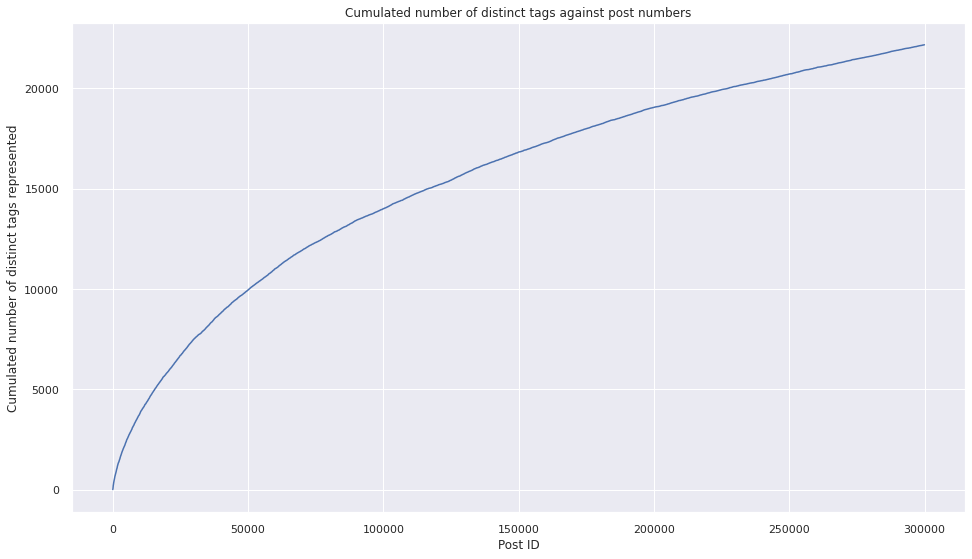

In [24]:
plt.title('Cumulated number of distinct tags against post numbers')
plt.xlabel('Post ID')
plt.ylabel('Cumulated number of distinct tags represented')
plt.plot(range(cnt_docs), cnt_distinct_tags_history)

## Most represented tags

In [25]:
{k: v for k, v in sorted(tokens_tags.items(), key=lambda item: item[1], reverse=True)}

{'python': 22465,
 'javascript': 16466,
 'java': 9783,
 'html': 6763,
 'android': 6534,
 'c#': 6427,
 'reactjs': 6185,
 'php': 5495,
 'python-3.x': 5138,
 'node.js': 4693,
 'c++': 4526,
 'css': 4335,
 'r': 4167,
 'pandas': 3529,
 'sql': 3351,
 'angular': 3287,
 'flutter': 2944,
 'django': 2804,
 'mysql': 2777,
 'swift': 2657,
 'jquery': 2549,
 'arrays': 2538,
 'ios': 2412,
 'typescript': 2375,
 'c': 2304,
 'json': 2172,
 'laravel': 2141,
 'firebase': 1953,
 'react-native': 1884,
 'spring-boot': 1846,
 'excel': 1746,
 'vue.js': 1598,
 'dataframe': 1568,
 'amazon-web-services': 1539,
 'docker': 1498,
 'mongodb': 1477,
 'wordpress': 1463,
 'dart': 1404,
 'sql-server': 1400,
 'spring': 1375,
 'linux': 1367,
 'regex': 1351,
 'kotlin': 1303,
 'vba': 1297,
 'postgresql': 1280,
 'tensorflow': 1270,
 'android-studio': 1228,
 'database': 1201,
 'numpy': 1193,
 'api': 1156,
 'list': 1150,
 'azure': 1101,
 'express': 1082,
 'asp.net-core': 1021,
 'windows': 1003,
 'selenium': 984,
 'flask': 955,
 

# Cumulated number of posts agains

In [26]:
tags_represented_posts_cumulated = np.cumsum([v for k, v in sorted(tokens_tags.items(), key=lambda item: item[1], reverse=True)])

In [27]:
tags_represented_posts_cumulated.max()*0.8

360914.4

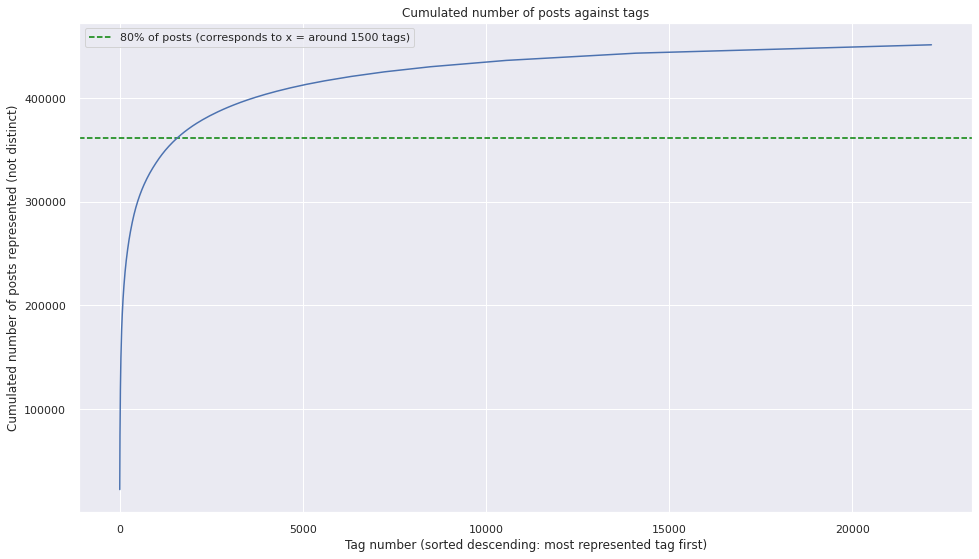

In [28]:
plt.title('Cumulated number of posts against tags')
plt.xlabel('Tag number (sorted descending: most represented tag first)')
plt.ylabel('Cumulated number of posts represented (not distinct)')
plt.axhline(tags_represented_posts_cumulated.max() * 0.80, color='green', linestyle='--', label=f"80% of posts (corresponds to x = around 1500 tags)")
plt.legend()
plt.plot(range(len(tags_represented_posts_cumulated)), tags_represented_posts_cumulated)

In [29]:
tags_represented_posts_cumulated[1500]

359098

## Most represented tokens

In [30]:
{k: v for k, v in sorted(tokens_body.items(), key=lambda item: item[1], reverse=True)}

{'.': 4366716,
 ';': 1992348,
 ',': 1898453,
 ':': 1566136,
 '(': 1554823,
 '&': 1469415,
 'the': 1300237,
 '-': 1190985,
 'gt': 1103121,
 '=': 1086388,
 'lt': 951559,
 '"': 912521,
 'to': 866296,
 "'": 767463,
 '/': 764702,
 ')': 750417,
 'I': 709511,
 'a': 611425,
 '{': 596487,
 '0': 513006,
 '}': 495468,
 'is': 488067,
 'in': 467558,
 'and': 442271,
 '1': 433985,
 '="': 369067,
 'of': 364987,
 'this': 361958,
 'it': 309435,
 '[': 306022,
 ';/': 299390,
 'for': 292650,
 'that': 253106,
 'you': 251592,
 ');': 248756,
 '2': 230658,
 '",': 226015,
 'if': 224961,
 '()': 210266,
 'with': 204734,
 'i': 200774,
 'class': 181310,
 'have': 179610,
 'from': 177323,
 "',": 175703,
 'can': 174564,
 '\\': 172341,
 '$': 171600,
 'as': 170347,
 'not': 169013,
 'on': 167875,
 '("': 162076,
 ']': 161931,
 ';&': 160298,
 'data': 159934,
 '3': 157255,
 'be': 154878,
 '?': 154425,
 '#': 153181,
 '//': 152774,
 '"&': 150307,
 '+': 140505,
 '":': 140392,
 'return': 137583,
 'but': 135490,
 'my': 134379,
 